In [1]:
import sys
sys.path.append("../") 

In [2]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.Resize([150,150]),
    transforms.ToTensor(),
    transforms.Normalize(mean=0,std=1)
])

In [4]:
training_path='/media/sergio/Backup/data/COVID-19_Radiography_Dataset/split_data/train'
testing_path='/media/sergio/Backup/data/COVID-19_Radiography_Dataset/split_data/val'

In [5]:
num_gpus = 1
model_ctx = mx.gpu()

num_workers = 4
batch_size = 64 

train_data = mx.gluon.data.vision.datasets.ImageFolderDataset(training_path).transform_first(transform)
test_data = mx.gluon.data.vision.datasets.ImageFolderDataset(testing_path).transform_first(transform)

In [6]:
train_data_loader = mx.gluon.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=num_workers)
valid_data_loader = mx.gluon.data.DataLoader(test_data, batch_size, num_workers=num_workers)

In [7]:
for X,y in train_data_loader:
    print(X.shape)
    print(y.shape)
    break

(64, 3, 150, 150)
(64,)


In [8]:
model_ctx

gpu(0)

# Bayesian inference for Covid X-Ray

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)



# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [15]:
import mxnet as mx
from mxnet import nd, autograd, gluon

hyper={'alpha':10.}
in_units=(3,150,150)
out_units=4
n_layers=18
pre_trained=False

In [16]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import resnet_softmax

model=resnet_softmax(hyper,in_units,out_units,n_layers,pre_trained,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

MXNetError: Traceback (most recent call last):
  File "/home/sergio/code/mxnet/include/mxnet/base.h", line 449
CUDA: Check failed: e == cudaSuccess (804 vs. 0) : forward compatibility was attempted on non supported HW

In [16]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.resnet_softmax)
    importlib.reload(hamiltonian.inference.sgd)
    importlib.reload(hamiltonian.inference.base)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


no modules loaded yet


 10%|█         | 1/10 [03:58<35:50, 238.90s/it]

loss: 4.0159


 20%|██        | 2/10 [10:19<42:56, 322.02s/it]

loss: 3.6433


 30%|███       | 3/10 [16:38<40:37, 348.28s/it]

loss: 3.5201


 40%|████      | 4/10 [22:57<36:01, 360.19s/it]

loss: 3.4436


 50%|█████     | 5/10 [29:15<30:33, 366.72s/it]

loss: 3.3982


 60%|██████    | 6/10 [35:33<24:42, 370.71s/it]

loss: 3.3690


 70%|███████   | 7/10 [41:52<18:39, 373.27s/it]

loss: 3.3310


 80%|████████  | 8/10 [48:11<12:30, 375.08s/it]

loss: 3.3001


 90%|█████████ | 9/10 [54:30<06:16, 376.31s/it]

loss: 3.2658


100%|██████████| 10/10 [1:00:49<00:00, 364.95s/it]

loss: 3.2634


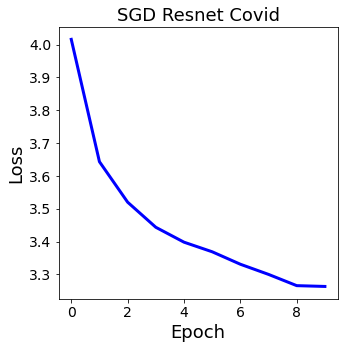

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


train_sgd=False
num_epochs=10

if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,data_loader=train_data_loader,verbose=True)

    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Resnet Covid', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_covid.pdf', bbox_inches='tight')
    model.net.save_parameters('../scripts/results/covid/covid_sgd_'+str(num_epochs)+'_epochs.params')
else:
    model.net.load_parameters('../scripts/results/covid/covid_sgd_'+str(num_epochs)+'_epochs.params',ctx=model_ctx)
    par=dict()
    for name,gluon_par in model.net.collect_params().items():
        par.update({name:gluon_par.data()})
    

In [19]:
total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=100,data_loader=train_data_loader)

In [20]:
y_hat=np.quantile(total_samples,.5,axis=0)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2888
           1       0.98      0.90      0.94      4797
           2       0.95      0.99      0.97      8136
           3       0.99      1.00      0.99      1075

    accuracy                           0.97     16896
   macro avg       0.97      0.97      0.97     16896
weighted avg       0.97      0.97      0.97     16896



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [32]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import resnet_softmax

model=resnet_softmax(hyper,in_units,out_units,n_layers,pre_trained,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

In [33]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=True
num_epochs=10

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data_loader,
                                verbose=True,chain_name='chain_nonhierarchical')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Resnet COVID', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_covid.pdf', bbox_inches='tight')
else:
    chain1=glob.glob("../scripts/results/covid/chain_nonhierarchical_0_1_sgld*")
    chain2=glob.glob("../scripts/results/covid/chain_nonhierarchical_0_sgld*")
    posterior_samples=[chain1,chain2]

 10%|█         | 1/10 [02:22<21:20, 142.30s/it]

loss: 558327.7187


 20%|██        | 2/10 [08:44<37:46, 283.26s/it]

loss: 2202420.8354


 20%|██        | 2/10 [08:50<35:22, 265.28s/it]


KeyboardInterrupt: 

In [ ]:
posterior_samples_flat=[item for sublist in posterior_samples for item in sublist]

In [ ]:
total_samples,total_labels,log_like=inference.predict(posterior_samples_flat,5,data_loader=val_data)

In [ ]:
from sklearn.metrics import classification_report
posterior_samples

y_hat=np.quantile(total_samples,.9,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

In [ ]:
from sklearn.metrics import f1_score

score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), average='macro'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

In [ ]:
import arviz as az

posterior_samples_multiple_chains=inference.posterior_diagnostics(posterior_samples)
datasets=[az.convert_to_inference_data(sample) for sample in posterior_samples_multiple_chains]
dataset = az.concat(datasets, dim="chain")
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}

In [ ]:
az.summary(dataset)

In [ ]:
print(mean_r_hat_values)

In [ ]:
print(mean_ess_values)

In [ ]:
print(mean_mcse_values)

In [ ]:
from hamiltonian.psis import *

loo,loos,ks=psisloo(-log_like)

In [ ]:
from sklearn.metrics import f1_score

score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), sample_weight=loos,average='weighted'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))